In [ ]:
import time
import gzip
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import gensim
import torch
from torch import nn, optim
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.dataset import random_split
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device('cpu')

**Mount drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Read dataset

In [ ]:
dataset = pd.read_csv("/content/drive/MyDrive/Datasets/dataset.csv")
dataset.sample(5)

,text,fake,clean_text,clean_text_without_freq_words
1370,Canine caper: Cape Town woman pays R500 ransom...,False,canine caper cape town woman pay r500 ransom d...,canine caper cape town woman pay r500 ransom d...
499,2018 Rolls-Royce Wraith Wraith: R 7 950 000 1 ...,True,2018 rollsroyce wraith wraith r 7 950 000 1 wh...,2018 rollsroyce wraith wraith r 7 950 000 1 wh...
1050,Man on trial for horrific knife attack on frie...,False,man trial horrific knife attack friend parent ...,man trial horrific knife attack friend parent ...
710,You can lodge a complain – grievance to SASSA ...,True,lodge complain grievance sassa declined r350 g...,lodge complain grievance sassa declined r350 g...
1251,"One killed, 8 injured following 3-vehicle coll...",True,one killed 8 injured following 3vehicle collis...,killed 8 injured following 3vehicle collision ...


# Split the dataset

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(dataset['clean_text'],dataset['fake'],
                                                test_size=0.2, random_state=1)
print(f'X: Training set {X_train.shape}, Testing set {X_test.shape}')
print(f'y: Training set {y_train.shape}, Testing set {y_test.shape}')

X: Training set (1168,), Testing set (292,)
y: Training set (1168,), Testing set (292,)


#Vectorization: Word2Vec

## 1 Create preprocessed corpus(list of lists of n-grams)

In [ ]:
# Create a list of lists of unigrams
def create_unigrams_list(corpus):
  corpus_lst = []

  for article in corpus:
    words_lst = article.split()    
    grams_lst = [" ".join(words_lst[i:i+1]) for i in range(0, len(words_lst), 1)]
    corpus_lst.append(grams_lst)
  return corpus_lst

In [ ]:
corpus_lst = create_unigrams_list(dataset['clean_text'])
corpus_lst_train = create_unigrams_list(X_train.copy())
corpus_lst_test =  create_unigrams_list(X_test.copy())

## 2 Embedding model (Word2Vec)

In [ ]:
# Embedding model
word2vec = gensim.models.word2vec.Word2Vec(corpus_lst, size=300, window=5, min_count=1, sg=1)

## 3 Vocabulary

In [ ]:
# Vocab size
print('Vocab size:',len(word2vec.wv.vocab))

Vocab size: 29746


In [ ]:
# Example
word2vec.wv.most_similar('police')

[('sap', 0.8360641002655029),
 ('officer', 0.811168909072876),
 ('station', 0.8068121671676636),
 ('suspect', 0.8046930432319641),
 ('naidoo', 0.79648357629776),
 ('naidu', 0.7940928339958191),
 ('brigadier', 0.7920454740524292),
 ('commander', 0.7919169664382935),
 ('thembeka', 0.7894965410232544),
 ('ipid', 0.7891992330551147)]

# 1. Feature Engineering

## 1.1 Prepare Tokens

In [ ]:
# Create tokenizer
k_tokenizer = Tokenizer(oov_token="NaN", num_words=300)
k_tokenizer.fit_on_texts(corpus_lst)
vocab = k_tokenizer.word_index

# Tokenize training text
train_text2seq = k_tokenizer.texts_to_sequences(corpus_lst_train)
X_train_tkns = sequence.pad_sequences(train_text2seq, maxlen=250,padding="post", truncating="post")
print(f'Training text {X_train_tkns.shape}')

# Tokenize testing text
test_text2seq = k_tokenizer.texts_to_sequences(corpus_lst_test)
X_test_tkns = sequence.pad_sequences(test_text2seq, maxlen=250,padding="post", truncating="post")
print(f'Testing text {X_test_tkns.shape}')

Training text (1168, 250)
Testing text (292, 250)


## 1.2 Create datasets

In [ ]:
# Custom Dataset
class NewsDataset(Dataset):
  def __init__(self, tokens, labels):
    self.tokens = torch.from_numpy(tokens)
    self.labels = torch.from_numpy(labels.to_numpy())

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    return  self.labels[idx], self.tokens[idx]

In [ ]:
train_dataset = NewsDataset(X_train_tkns, y_train)
test_dataset = NewsDataset(X_test_tkns, y_test)

## 1.4 Create dataloaders

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=5, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=5, shuffle=False)

## 1.5 Ensure things make sense

In [ ]:
idx = 0

# Text
text = X_train.iloc[idx]
print(f'from: {text},\n len:{len(text.split())}')

# Tokens
# labels, tokens = next(iter(train_dataloader))
labels, tokens = train_dataset[idx]
print(f'to: {tokens.tolist()}')

# Check
print(f'Check: {text.split()[0]} => idx in vocab: {vocab[text.split()[0]]}')

from: expropriate land western cape malema tell supporter eff leader julius malema told resident kayamandi stellenbosch party would expropriate land western cape come power malema kicked party election campaign province thursday 10 day resident expected cast voteskayamandi resident came number rallythe area plagued year problem unemployment lack housingresidents told malema issue faced daily basis saying toilet access residential waste collection service proper housing malema wasted time criticising anc da governance nationally provincially stellenbosch racist town want change scared eff change place better eff want everyone stand together one said malema added running water flushing toilet area lashed anc da supplying adequate toilet housing lived informal settlement animal dont running water flushing toilet da anc treat u like animal need electricity wait housing electricity people need electricity malema said 2016 municipal election da received majority 30 seat councilthese white fa

# Deep Learning Model

## 1 Create News classification models

In [ ]:
class SimpleLSTMClassifier(nn.Module):

  def __init__(self, vocab_size, embed_dim, hidden, n_layers, num_class, weights):
    super(SimpleLSTMClassifier, self).__init__()

    self.n_layers = n_layers
    self.hidden = hidden

    self.embedding = nn.Embedding.from_pretrained(weights, freeze=True)
    # self.embedding = nn.Embedding(vocab_size, embed_dim)

    self.lstm = nn.LSTM(embed_dim, hidden, num_layers=n_layers, 
                        bidirectional=True, dropout=0.2, batch_first=True)
    
    self.fc = nn.Linear(hidden* 2, num_class)

    self.sig = nn.Sigmoid()

  def forward(self, text):

    emb = self.embedding(text)

    h = torch.zeros((self.n_layers*2, text.size(0), self.hidden)).to(DEVICE)
    c = torch.zeros((self.n_layers*2, text.size(0), self.hidden)).to(DEVICE)
    nn.init.xavier_normal_(h)
    nn.init.xavier_normal_(c)

    out,(hidden,cell) = self.lstm(emb, (h,c))

    hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)

    output = self.fc(hidden)
    return self.sig(output)

In [ ]:
class NewsClassificationModel(nn.Module):

  def __init__(self, vocab_size, embed_dim, num_class, weight):
    super(NewsClassificationModel, self).__init__()

    # self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
    self.embedding_bag = nn.EmbeddingBag.from_pretrained(weight, freeze=True)
    self.fc1 = nn.Linear(embed_dim,num_class)
    # self.fc2 = nn.Linear(32,num_class)
    self.sig = nn.Sigmoid()
    # self.relu = nn.ReLU()

    self.__init_weights()

  def __init_weights(self):
    initrange = 0.5
    # self.embedding.weight.data.uniform_(-initrange, initrange)
    self.fc1.weight.data.uniform_(-initrange, initrange)
    self.fc1.bias.data.zero_()
    # self.fc2.weight.data.uniform_(-initrange, initrange)
    # self.fc2.bias.data.zero_()

  def forward(self, text, offsets):
    # embedded = self.embedding(text, offsets)
    embedded = self.embedding_bag(text, offsets)

    # Last linear layers
    out = self.fc1(embedded)
    # out = self.relu(out)
    # out = self.fc2(out)

    return self.sig(out)

## 2 Training loop

In [ ]:
def train_model(model,dataloader,curr_epoch,criterion,optimizer,print_freq = 2):
  model.train()
  total_acc, total_count = 0,0
  running_loss = 0.0
  

  for idx, (label, text) in enumerate(dataloader):
    label = label.to(DEVICE)
    text = text.to(DEVICE)


    optimizer.zero_grad()
    probs = model(text)

    preds = torch.round(probs)
    label = torch.unsqueeze(label, 1)
    label = label.to(torch.float)

    loss = criterion(preds, label)

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 0.1)
    optimizer.step()

    total_acc += (preds == label).sum().item()
    total_count += label.size(0)
    running_loss += loss.item() * label.size(0)

    if idx % print_freq == 0:
      print(f'epoch {curr_epoch} | {idx}/{len(dataloader)} batches | accuracy {total_acc/total_count}')
      total_acc, total_count = 0,0

  epoch_loss = running_loss / total_count
  epoch_acc = total_acc / total_count
  return epoch_loss, epoch_acc

## 3 Evaluation Loop

In [ ]:
def eval_model(model, dataloader, criterion,is_test=False):
  model.eval()

  total_acc, total_count = 0, 0
  running_loss = 0.0
  pred_probs = []
  final_preds = []

  with torch.no_grad():
    for idx, (label, text) in enumerate(dataloader):
      label = label.to(DEVICE)
      text = text.to(DEVICE)
      
      probs = model(text)

      preds = torch.round(probs)
      if is_test:
        pred_probs.append(probs.cpu().tolist())
        final_preds.append(preds.cpu().tolist())
      
      label = torch.unsqueeze(label, 1)
      label = label.to(torch.float)

      loss = criterion(preds, label)

      total_acc += (preds == label).sum().item()
      total_count += label.size(0)
      running_loss +=loss.item() * label.size(0)

  epoch_loss = running_loss / total_count
  epoch_acc = total_acc / total_count

  if is_test:
    return epoch_loss, epoch_acc, pred_probs,final_preds
  else:
    return epoch_loss, epoch_acc

## 4 Run the model

In [ ]:
def run(model, num_epochs, dataloader, criterion, optimizer, scheduler,seed):
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

  tot_start_time = time.time()
  total_acc = None

  history = {
      'train': {'loss':np.zeros(num_epochs), 'acc':np.zeros(num_epochs)},
      'valid': {'loss':np.zeros(num_epochs), 'acc':np.zeros(num_epochs)},
  }

  for epoch in range(1, num_epochs+1):
    epoch_start_time = time.time()
    
    # Training
    train_loss, train_acc = train_model(model, dataloader['train'], epoch, criterion, optimizer )
    history['train']['loss'][epoch-1] = train_loss
    history['train']['acc'][epoch-1] = train_acc

    # Validation
    val_loss, val_acc = eval_model(model, dataloader['valid'], criterion)
    history['train']['loss'][epoch-1] = val_loss
    history['train']['acc'][epoch-1] = val_acc

    if total_acc is not None and total_acc > val_acc:
      scheduler.step()
    else:
      total_acc = val_acc

    print('-'*60)
    print(f'end of epoch {epoch} | time:{time.time() - epoch_start_time}s | valid accuracy {val_acc}')
    print('-'*60)
  
  print(f'Elapsed time {time.time() - tot_start_time}')
  return history

## 5 Training

### 5.1 Initialise

In [ ]:
hyper_params = {
    'epochs': 10,
    'batch-size': 32,
    'learning-rate':1e-3,
    'num-classes':1,
    'embedding-size': 300,
    'hidden-dim':32,
    'num-layers':2,
    'seed':2021
}

# word2vec weight matrix
word2vec_weights = torch.FloatTensor(word2vec.wv.vectors)

# Model 
vocab_size = len(vocab)
news_model = SimpleLSTMClassifier(vocab_size, hyper_params['embedding-size'],hyper_params['hidden-dim'],
                                  hyper_params['num-layers'], hyper_params['num-classes'],weights=word2vec_weights).to(DEVICE)
print(news_model)

# criterion
criterion = nn.BCELoss()

# Optimizer 
optimizer = optim.Adam(news_model.parameters(), lr=hyper_params['learning-rate'])

# Scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)

SimpleLSTMClassifier(
  (embedding): Embedding(29746, 300)
  (lstm): LSTM(300, 32, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (sig): Sigmoid()
)


### 5.2 Datasets

In [ ]:
num_train = int(len(train_dataset) * 0.75)
split_train_, split_valid_ = random_split(train_dataset, [num_train, len(train_dataset)-num_train])
print(f'Training dataset {len(split_train_)}')
print(f'Validation dataset {len(split_valid_)}')
print(f'Testing dataset {len(test_dataset)}')

train_dataloader = DataLoader(split_train_, batch_size=hyper_params['batch-size'], shuffle=True)
valid_dataloader = DataLoader(split_valid_, batch_size=hyper_params['batch-size'], shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=hyper_params['batch-size'], shuffle=False)

dataloader = {
    'train': train_dataloader,
    'valid': valid_dataloader
}

Training dataset 876
Validation dataset 292
Testing dataset 292


### 5.3 Train the model

In [ ]:
train_history = run(news_model, hyper_params['epochs'], dataloader, criterion, optimizer, scheduler,seed=hyper_params['seed'])

epoch 1 | 0/28 batches | accuracy 0.375
epoch 1 | 2/28 batches | accuracy 0.5
epoch 1 | 4/28 batches | accuracy 0.484375
epoch 1 | 6/28 batches | accuracy 0.390625
epoch 1 | 8/28 batches | accuracy 0.46875
epoch 1 | 10/28 batches | accuracy 0.4375
epoch 1 | 12/28 batches | accuracy 0.5
epoch 1 | 14/28 batches | accuracy 0.578125
epoch 1 | 16/28 batches | accuracy 0.53125
epoch 1 | 18/28 batches | accuracy 0.4375
epoch 1 | 20/28 batches | accuracy 0.515625
epoch 1 | 22/28 batches | accuracy 0.453125
epoch 1 | 24/28 batches | accuracy 0.5
epoch 1 | 26/28 batches | accuracy 0.484375
------------------------------------------------------------
end of epoch 1 | time:10.99885368347168s | valid accuracy 0.5376712328767124
------------------------------------------------------------
epoch 2 | 0/28 batches | accuracy 0.46875
epoch 2 | 2/28 batches | accuracy 0.5
epoch 2 | 4/28 batches | accuracy 0.46875
epoch 2 | 6/28 batches | accuracy 0.421875
epoch 2 | 8/28 batches | accuracy 0.421875
epoch 

### 5.4 Plots and Evaluation metrics

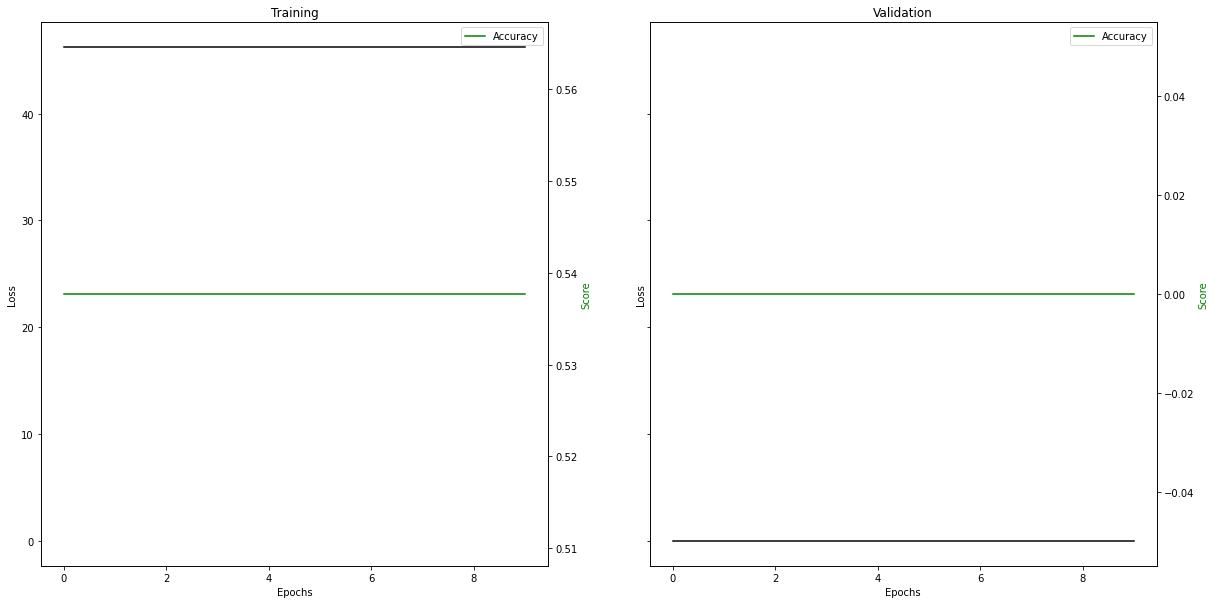

In [ ]:
# Plot loss and accuracy
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10) , sharey=True)

ax11 = ax[0].twinx()
ax[0].plot(train_history['train']['loss'], color='black',label='Loss')
ax[0].set_title('Training')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
ax11.plot(train_history['train']['acc'], color='green', label='Accuracy')
ax11.set_ylabel('Score', color='green')
ax11.legend()

ax22 = ax[1].twinx()
ax[1].plot(train_history['valid']['loss'], color='black',label='Loss')
ax[1].set_title('Validation')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')
ax22.plot(train_history['valid']['acc'], color='green', label='Accuracy')
ax22.set_ylabel('Score', color='green')
ax22.legend()

plt.show()
fig.savefig('train_val_acc_loss.png')

## 6 Inference

In [ ]:
print('Check results of the test dataset')
test_loss, test_acc, test_probs, test_preds = eval_model(news_model,test_dataloader, criterion,is_test=True)
print(f'Test accuracy {test_acc}')

Check results of the test dataset
Test accuracy 0.4863013698630137


### 6.1 Metrics

In [ ]:
import itertools
chain_probs = itertools.chain(*test_probs)
chain_preds = itertools.chain(*test_preds)
test_probs = np.array(list(chain_probs))
test_preds = np.array(list(chain_preds),dtype=bool)

In [ ]:
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix

auc = metrics.roc_auc_score(y_test.to_numpy(), test_probs)
report = metrics.classification_report(y_test.to_numpy(), test_preds )

print(f'AUC: {round(auc,2)}')
print(report)

AUC: 0.56
              precision    recall  f1-score   support

       False       0.00      0.00      0.00       150
        True       0.49      1.00      0.65       142

    accuracy                           0.49       292
   macro avg       0.24      0.50      0.33       292
weighted avg       0.24      0.49      0.32       292



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


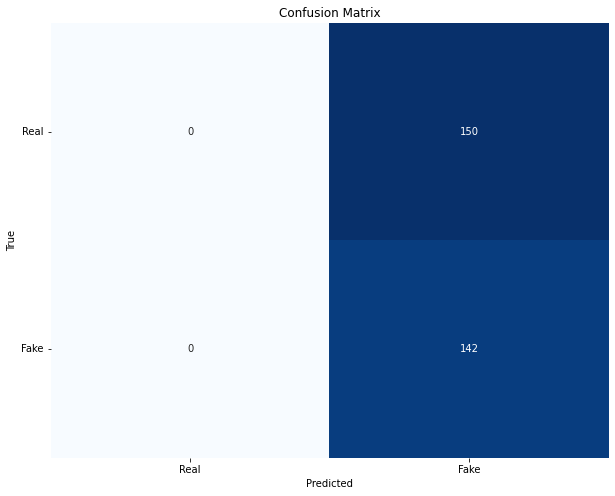

In [ ]:
# Confusion Matrix
cm = metrics.confusion_matrix(y_test.to_numpy(), test_preds)
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='Blues', cbar=False)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_xticklabels(['Real', 'Fake'])
ax.set_yticklabels(['Real', 'Fake'])
ax.set_title('Confusion Matrix')
plt.yticks(rotation=0)
fig.savefig('nn_confusion_matrix.png')

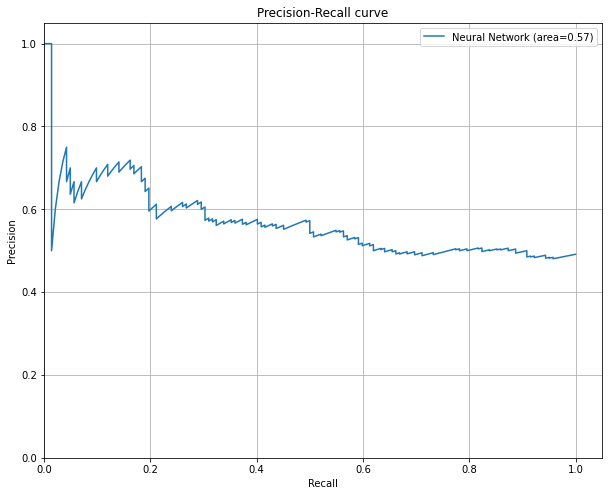

In [ ]:
# Precision-Recall curve
fig, ax = plt.subplots(figsize=(10,8))
precision, recall, thresh = metrics.precision_recall_curve(y_test.to_numpy(),test_probs)
ax.plot(recall, precision,label=f'Neural Network (area={round(metrics.auc(recall, precision),2)})')
ax.set_xlim([0.0,1.05])
ax.set_ylim([0.0,1.05])
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall curve')
ax.legend(loc='best')
ax.grid(True)
plt.show()
fig.savefig('nn_prec_rec_curve.png')

# Deep Learning Model(pretrained)

## 1 Pretrained Word2Vec vectors

In [ ]:
from gensim.test.utils import datapath

pretrained_word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/MyDrive/Datasets/GoogleNews-vectors-negative300.bin', binary=True)

## 2 Training

### 2.1 Initialise

In [ ]:
# Vocabulary size
pre_vocab_size = len(pretrained_word2vec_model.vocab)

# Pretrained weights
pre_word2vec_weights = torch.FloatTensor(pretrained_word2vec_model.vectors)

# Classifier Model
pre_news_model = SimpleLSTMClassifier(pre_vocab_size, hyper_params['embedding-size'], hyper_params['hidden-dim'],
                                      hyper_params['num-layers'], hyper_params['num-classes'], weights=pre_word2vec_weights ).to(DEVICE)
print(pre_news_model)


# Optimizer
pre_optimizer = optim.Adam(pre_news_model.parameters(), lr=hyper_params['learning-rate'])

# Scheduler
pre_scheduler = optim.lr_scheduler.StepLR(pre_optimizer, 1.0, gamma=0.1)

SimpleLSTMClassifier(
  (embedding): Embedding(3000000, 300)
  (lstm): LSTM(300, 32, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (sig): Sigmoid()
)


### 2.3 Train the model

In [ ]:
run(pre_news_model, hyper_params['epochs'], dataloader, criterion, pre_optimizer, pre_scheduler, hyper_params['seed'])

epoch 1 | 0/28 batches | accuracy 0.34375
epoch 1 | 2/28 batches | accuracy 0.5
epoch 1 | 4/28 batches | accuracy 0.46875
epoch 1 | 6/28 batches | accuracy 0.40625
epoch 1 | 8/28 batches | accuracy 0.484375
epoch 1 | 10/28 batches | accuracy 0.46875
epoch 1 | 12/28 batches | accuracy 0.53125
epoch 1 | 14/28 batches | accuracy 0.578125
epoch 1 | 16/28 batches | accuracy 0.515625
epoch 1 | 18/28 batches | accuracy 0.453125
epoch 1 | 20/28 batches | accuracy 0.515625
epoch 1 | 22/28 batches | accuracy 0.421875
epoch 1 | 24/28 batches | accuracy 0.5
epoch 1 | 26/28 batches | accuracy 0.484375
------------------------------------------------------------
end of epoch 1 | time:10.90559434890747s | valid accuracy 0.541095890410959
------------------------------------------------------------
epoch 2 | 0/28 batches | accuracy 0.46875
epoch 2 | 2/28 batches | accuracy 0.46875
epoch 2 | 4/28 batches | accuracy 0.46875
epoch 2 | 6/28 batches | accuracy 0.4375
epoch 2 | 8/28 batches | accuracy 0.437

{'train': {'acc': array([0.54109589, 0.54452055, 0.53767123, 0.53767123, 0.53767123,
         0.53767123, 0.54109589, 0.53767123, 0.53767123, 0.53767123]),
  'loss': array([45.89041096, 45.54794521, 46.23287671, 46.23287671, 46.23287671,
         46.23287671, 45.89041096, 46.23287671, 46.23287671, 46.23287671])},
 'valid': {'acc': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  'loss': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}}

## 3 Inference

In [ ]:
print('Check results of the test dataset')
pre_test_loss, pre_test_acc = eval_model(pre_news_model,test_dataloader, criterion)
print(f'Test accuracy {pre_test_acc}')

Check results of the test dataset
Test accuracy 0.4863013698630137
